### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [11]:
# gpu info that is allocated
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 13 03:48:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%%shell
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2020-06-13 02:52:05--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  1009KB/s    in 48s     

2020-06-13 02:52:53 (1.06 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-06-13 02:52:53--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-06-13 02:52:53--
Total wall clock time: 49s
Downloaded: 1 files, 51M in 48s (1.06 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

This Notebook is inspired from <br>
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset<br>

For this tutorial, we will be finetuning a pre-trained Mask R-CNN model in the `Penn-Fudan Database for Pedestrian Detection and Segmentation`. It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

In [0]:
pwd

'/content'

### Defining Dataset <br>
The reference scripts for training object detection, instance segmentation and person keypoint detection allows for easily supporting adding new custom datasets. The dataset should inherit from the standard torch.utils.data.Dataset class, and implement `__len__` and `__getitem__`.

In [0]:
import os
import sys
import time
import numpy as np
import torch
import PIL
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import math
from sklearn.metrics import auc
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import functional as F

import gc

%matplotlib inline

In [13]:
torch.__version__

'1.5.0+cu101'

In [0]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(self.root,"PNGImages")))) # returns a list of file names, sorting and converting it into list again
        self.masks  = list(sorted(os.listdir(os.path.join(self.root,"PedMasks")))) # returns a list of file names
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path  = os.path.join(self.root,"PNGImages",self.images[index])
        mask_path = os.path.join(self.root,"PedMasks",self.masks[index])
        # load the images using PIL and convert to RGB
        img = Image.open(img_path).convert("RGB")
        # Load the mask, we do not convert mask to RGB since mask is just a number for instances of object
        # present in the image, (0 is for backrground)
        mask = Image.open(mask_path)        
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None] # separate binary mask for each instance
        
        # get bounding box coordinates for each mask
        num_obj = len(obj_ids)
        boxes = []
        
        for i in range(num_obj):
            curr_mask = np.where(masks[i])
            xmin = np.min(curr_mask[1])
            xmax = np.max(curr_mask[1])
            ymin = np.min(curr_mask[0])
            ymax = np.max(curr_mask[0])
            assert (xmin * xmax * ymin * ymax) >0  
            boxes.append([xmin,ymin,xmax,ymax])
            
        # convert everything into Torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class in this database, Pedestrian since we removed background
        labels = torch.ones((num_obj,), dtype=torch.int64)
        masks = torch.as_tensor(masks.astype('uint8'), dtype=torch.uint8)
        
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target        

Number of images in dataset: 170
image shape is: (359, 486, 3)
Number of Instances in Image: 5


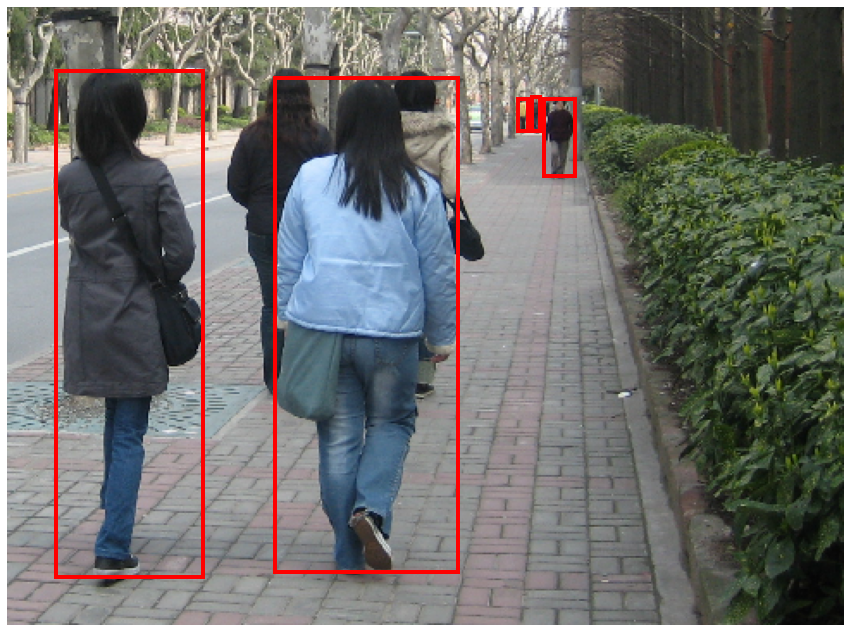

In [15]:
root = "/content/PennFudanPed/"
PennFudanDataset_obj = PennFudanDataset(root)
print(f'Number of images in dataset: {len(PennFudanDataset_obj)}')
# get a random image from the dataset
im_id = np.random.choice(len(PennFudanDataset_obj))
image, target = PennFudanDataset_obj[im_id]
print(f'image shape is: {np.array(image).shape}')
fig, ax = plt.subplots(1, figsize=(15,20))
ax.imshow(image)
ax.axis('off')
print(f'Number of Instances in Image: {target["boxes"].shape[0]}')
# draw bounding boxes
num_obj = target["boxes"].shape[0]
for i in range(num_obj):
    # Create a Rectangle patch
    curr_box = (target["boxes"][i]).numpy()
    x0,y0,x1,y1 = curr_box[0], curr_box[1], curr_box[2], curr_box[3]
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0,y0),width,height,linewidth=4,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

In [64]:
im_id

13

(300, 300) (391, 492)
[[76, 70, 128, 277], [123, 61, 195, 280], [210, 67, 281, 261]]


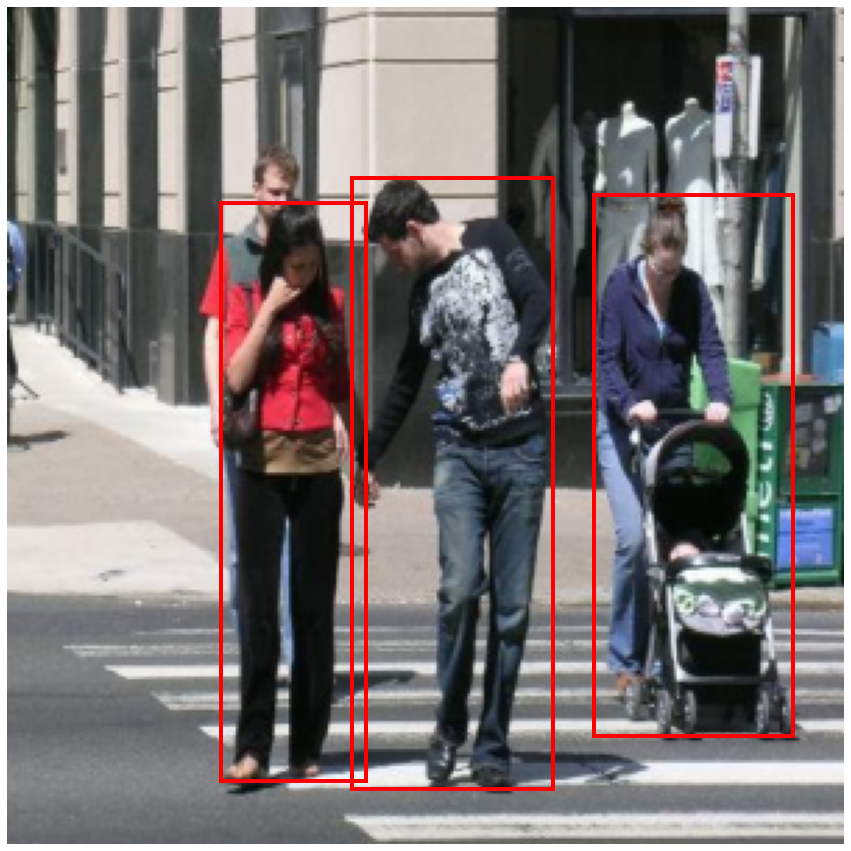

In [0]:
if 0:
  index = 100
  images = list(sorted(os.listdir(os.path.join(root,"PNGImages")))) # returns a list of file names, sorting and converting it into list again
  masks  = list(sorted(os.listdir(os.path.join(root,"PedMasks")))) # returns a list of file names
  img_path  = os.path.join(root,"PNGImages",images[index])
  mask_path = os.path.join(root,"PedMasks",masks[index])
  # load the images using PIL and convert to RGB
  img = Image.open(img_path).convert("RGB")
  w, h = img.size # this returns width/height
  img = img.resize((300,300), PIL.Image.BILINEAR)

  scale_x, scale_y = 300/w, 300/h
  mask = Image.open(mask_path)
  mask = np.array(mask)
  print(img.size, np.array(mask).shape)
  # instances are encoded as different colors
  obj_ids = np.unique(mask)
  # first id is the background, so remove it
  obj_ids = obj_ids[1:]
  masks = mask == obj_ids[:, None, None]
  #print(masks.shape)
  # get bounding box coordinates for each mask
  num_obj = len(obj_ids)
  boxes = []

  for i in range(num_obj):
      curr_mask = np.where(masks[i])
      xmin = np.int(np.min(curr_mask[1])*scale_x)
      xmax = np.int(np.max(curr_mask[1])*scale_x)
      ymin = np.int(np.min(curr_mask[0])*scale_y)
      ymax = np.int(np.max(curr_mask[0])*scale_y)
      #w = abs(xmax - xmin)
      #h = abs(ymax - ymin)
      
      #if min(h,w) < 20: # skip bounding boxes if height or width < 20 pixels
      #  continue

      boxes.append([xmin,ymin,xmax,ymax])
  print(boxes)
  fig, ax = plt.subplots(1, figsize=(15,20))
  ax.imshow(img)
  ax.axis('off')
  for i in range(len(boxes)):
      # Create a Rectangle patch
      curr_box = boxes[i]
      x0,y0,x1,y1 = curr_box[0], curr_box[1], curr_box[2], curr_box[3]
      width = x1 - x0
      height = y1 - y0
      rect = patches.Rectangle((x0,y0),width,height,linewidth=4,edgecolor='r',facecolor='none')
      # Add the patch to the Axes
      ax.add_patch(rect)
  plt.show()

# check the full model: fasterrcnn_resnet50_fpn
- We will be using  a  pre-trained faster RCNN with resnet50 backbone
- this section help you on how to explore the model architecture
- Few useful command to explore
  - model.named_chidren() : gives the immediate children of the base node
  - model._modules() :  gives the Ordered Dict
  - model.named_parameters() : gives the parameters the model recursively the last level
- Accesssing children of the model
  - model.backbone: to access the backbone sub-network of the base model
  - model.rpn: to access rpn sub-network and so on
-  Freezing paramters of whole/part of the model
  - Freezing parameters of whole model: 
         for p in model.parameters():
            p.requires_grad = False
  - Freezing parameters of backbone part of model:
         for p in model.backbone.parameters():
            p.requires_grad = False
  - Freezing parameters of any arbitrary module inside network:
         for p in model.roi_heads.box_head.fc6.parameters():
            p.requires_grad = False

In [9]:
# load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [10]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [0]:
# get names, children of model
for name, child in model.named_children():
  print(f'name is: {name}')
  print(f'module is: {child}')


name is: transform
module is: GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
name is: backbone
module is: BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

There are 4 children of the node **model** <br>
- transform
- backbone (this is resent50 with feature pyramid layer inside it)
- rpn (region proposal network)
- roi_heads(this is something we will tweak based on our requirement of transfer learning)

In [0]:
# gives the order Dict for the model
for key, value in model._modules.items():
  print(f'key is: {key}')
  print(f'value is: {value}')

key is: transform
value is: GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
key is: backbone
value is: BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [0]:
# get names, parameters of model
for name, param in model.named_parameters():
  print(f'name is: {name}')
  print(f'module is: {param}')

Streaming output truncated to the last 5000 lines.
         [[-1.1238e-02, -8.3475e-03, -1.3583e-02],
          [-1.6102e-02, -8.8688e-03, -1.7827e-02],
          [-1.2420e-02, -1.2392e-02, -1.3748e-02]],

         ...,

         [[ 6.4443e-03,  3.2407e-03,  1.5103e-02],
          [-4.4492e-03,  3.3583e-03,  1.4101e-02],
          [-1.0059e-02, -4.7799e-03,  1.3486e-02]],

         [[ 1.0707e-02, -4.6132e-04, -4.0186e-03],
          [-1.0992e-03,  4.9109e-03,  4.9758e-03],
          [ 1.8696e-03,  8.2267e-03,  6.6872e-03]],

         [[-2.7681e-03,  1.7530e-03,  6.8856e-03],
          [ 5.8272e-03,  1.1483e-04,  7.2060e-04],
          [ 5.1995e-03,  3.8445e-03,  5.0695e-03]]]], requires_grad=True)
name is: backbone.body.layer3.4.conv3.weight
module is: Parameter containing:
tensor([[[[ 4.4234e-05]],

         [[ 3.4302e-05]],

         [[-4.2633e-04]],

         ...,

         [[-8.7778e-04]],

         [[ 6.4271e-05]],

         [[ 1.2520e-03]]],


        [[[-1.2545e-02]],

         

In [0]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

`NOTE`: model.backbone has resnet50 backbone and feature pyramid layer as a part of backbone. In this notebook, we will not train the backbone and will freeze the parameters of backbone

In [0]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [0]:
isinstance(model.roi_heads.box_head.fc7, torch.nn.Linear)

True

**model** has 3 main parts <br>
- Backbone : will not be  trained
- rpn : will be trained
- roi_heads : will be replaced based on our # of classes requirements and will be obviously trained

In [0]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

- As you can see model.roi_heads consist of 2 FC layers and a box predictor layer. We will replace box predictor layer with a different head that will cater to our number of classes requirement. Further, I will freeze `fc6` layer as well so that we can train faster

In [0]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

- We need to put FastRCNNPredictor() which includes both bbox predictor and classification layer such that number of classes matches our requirement (In this case it will be 2 (1 for background and other for person)

# Define function which gives pre-trained model tuned to our requirements
- Lets define a function which will return our overall model with the classification layers replaced and backbone and other relevant layers frozen and lets save this initial model so that we can reload it state later

In [0]:
from torch.utils.checkpoint import checkpoint, checkpoint_sequential
########################################
## Custom Checkpoint
########################################

class CheckpointModule(torch.nn.Module):
  def __init__(self, module, num_segments=1):
    super(CheckpointModule, self).__init__()
    assert num_segments == 1 or isinstance(module, nn.Sequential)
    self.module = module
    self.num_segments = num_segments
    self.dummytensor = torch.ones(1, dtype=torch.float32, requires_grad=True)
       

  def forward(self, *inputs): 
    if self.num_segments > 1:
        return checkpoint_sequential(self._forward_patch_seq, self.dummytensor, self.num_segments, *inputs)
        
    else:
        return checkpoint(self._forward_patch, self.dummytensor, *inputs)

  def _forward_patch(self, dummy, *inputs):
    return self.module(*inputs)

  def _forward_patch_seq(self, dummytensor, num_segments, *inputs):
    return self.module(self.num_segments, *inputs)

     


def get_model(num_classes, chkptEn=False):
  '''
  num_classes : number for classification classes
  chkptEn : It enables gradient checkpointing when True at hard coded modules(manually changeable) inside model
  '''
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # attach proper classification head
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # freeze the backbone (it will freeze the body and fpn params)
  for p in model.backbone.parameters():
    p.requires_grad = False

  # freeze the fc6 layer in roi_heads
  for p in model.roi_heads.box_head.fc6.parameters():
    p.requires_grad = False

  if chkptEn==True:
    # wrap the model.roi_heads.box_head.fc7 under gradient checkpointing  
    model.roi_heads.box_head.fc7 = CheckpointModule(model.roi_heads.box_head.fc7)
    model.rpn.head.conv = CheckpointModule(model.rpn.head.conv)
    

  return model

model = get_model(num_classes=2)

# save the initial model
state = {
    'state_dict': model.state_dict()
    
}
torch.save(state, '/content/initialchkpt.pt')

In [18]:
 model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [0]:
# code snippet how to reload the state later
if 0: 
  state = torch.load('/content/initialchkpt.pt')
  model.load_state_dict(state['state_dict'])

Now we have our model ready

Define following `transform` classes we want to apply
- RandomHorizontalFlip
- ToTensor

In [0]:
class Rescale():

  def __init__(self, h, w):
    self.h = h
    self.w = w

  def __call__(self, image, target):
    w_, h_ = image.size # retuns width, height
    image = image.resize((self.w,self.h), PIL.Image.BILINEAR)
    scale_x, scale_y = self.w/w_, self.h/h_ # resizing ratio

    #scale the bounding boxes
    num_obj = len(target['boxes'])
    for i in range(num_obj):
      box = target['boxes'][i] #x0, y0, x1, y1
      box[0] *= scale_x
      box[2] *= scale_x
      box[1] *= scale_x
      box[3] *= scale_y
      target['boxes'][i] = box

    return image, target

class RandomHorizontalFlip():
    
    def __init__(self, p):
        self.p = p # probability of flip
        
    def __call__(self, image, target):
        if np.random.random() < self.p:
            # flip image horizontally
            image = torchvision.transforms.functional.hflip(image) # works on PIL image
            w, h  = image.size
            # flip mask horizontally
            #target['masks'] = target['masks'].flip(-1)
            #masks = target['masks'].numpy()# <num_obj, H, W> binary array
            #masks = np.flip(masks, axis=-1) # flip horizontally on width dimension
            #masks = torch.from_numpy(masks) # make torch tensor
            #target['masks'] = masks
            # flip the box cordinates horizontally
            boxes = target['boxes'] #x0, y0, x1, y1
            boxes[:,[0,2]] = w - boxes[:,[2,0]]
            # NOTE: ensure that boxes cordinate does not become negative, otherwise loss of the network will become NaN  
            assert (boxes > 0).all() > 0         
            return image, target 
        
        return image, target
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p})'
    
class ToTensor():
    
    def __call__(self, image, target):
        image = np.array(image)
        #image = image.transpose((2,0,1))
        return torchvision.transforms.functional.to_tensor(image), target # to_tensor permutes the image to have channel dim first
    
    def __repr__(self):
        return self.__class__.__name__ + f'()'
    
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [0]:
#train_transform_compose = Compose([ToTensor()])
train_transform_compose = Compose([RandomHorizontalFlip(p=0.5), ToTensor()])
#test_transform_compose = Compose([ToTensor()])
test_transform_compose = Compose([ToTensor()])

- *`collate_fn`*: Why are we defining a collate funtion <br>
In our case the input images are of differerent dimension, <channels, H, W> where height and width are not same across different input images. Our dataset `__getitem__` returns a tuple, i.e., image, target. <br>
- What happens if we do not define collate_fn to be passed to dataloader: In that case pyTorch by default vstacks the images which will throw error since they are not of same dimension, So this problem arises when we have variable length dataset
- custome `collate_fn` is our rescue: It accepts list ot tuples as arguement (since `__getitem__` of dataset class return a tuple and list of tuple is fed to the collate_fn), Now we can flatten the list (*batch) to get the tuples where 1st entry in a tuple is image, 2nd entry is the target dictionary for our case.  Then we can use zip operator on flattened list of tuples to get tuple of images and corresponding tuple of target dictionary. Now there won't be any problem with dataloader class



In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

##  create train and test dataset

In [23]:
train_dataset = PennFudanDataset(root, transforms=train_transform_compose)
test_dataset = PennFudanDataset(root, transforms=test_transform_compose)

# split the data b/w train and validation randomly
indx = np.random.choice(len(train_dataset), size=len(train_dataset), replace=False)
print(indx)
# train data
train_dataset_ = torch.utils.data.Subset(train_dataset, indx[:-50]) # keep but last 50 datapoints in train set
# valid data
test_dataset_ = torch.utils.data.Subset(test_dataset, indx[-50:]) # last 50 datapoints in validation set

# train dataloader
train_dataloader = DataLoader(train_dataset_, batch_size=2, shuffle=True, collate_fn=collate_fn)
# test dataloader
test_dataloader = DataLoader(test_dataset_, batch_size=2, shuffle=True, collate_fn=collate_fn)

[ 60  86  78 147  71  54 159  29  25 111 160 165 139  68  47  82  45 168
  83  39  95  72 151 146  26 124  38 128  91  73  32  62  97  31  79  48
 135 123   7  34 145  99  85  41 107 166  55 132 133  17  14  74  52 130
 169  44  75 144  36 121  93  59   6  77 117  67 113  92  65  61  57  13
 140 102  81 118 163 143   3 158 141  87  50 119 115   0  12  49 157 116
  28  88  37  40 134  80 103  63  58 164 142 114 149 109  24  76  11  42
 122 148 104  84  22  35 112 100 131  46  30  69  15 153   4 105 101  33
   9   8  53  23 167  51 110 137  70  19  10  94 127 154 120 155   2 162
 138 152  90  64  21  43 136 126   5  27 106 108  20 156  56  98  89  18
   1 125  16 150  96  66 129 161]


In [24]:
print(len(train_dataset_), len(test_dataset_))

120 50


- set up device, optimizer, learning scheduler

In [25]:
# setting up device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# setting optimizer
params = [p for p in  model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.005)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# set the model on device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

- define train_one_epoch function

In [0]:
x, y = next(iter(train_dataloader))

In [26]:
# number of batches
len(train_dataloader)

60

In [0]:
num_batches_train = len(train_dataloader)
num_batches_test  = len(test_dataloader)
def train_one_epoch(model, dataloader, optimizer, device):
    # set the model in train mode
    model.train()
    output = []
    batch_num = 0
    for images, targets in dataloader: # returns batch of data every iteration

      # send images in this batch to device
      images = list(image.to(device) for image in images) # list of images
      # send target dict in this bacth to device
      targets = [{k: v.to(device) for k,v in t.items()} for t in targets] # list of dict
      
      # zero out the gradients so that they do not accumulate (default behaviour) in successive passes
      optimizer.zero_grad()
      
      # forward pass
      try:
        op = model(images, targets)
      except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
          print('| WARNING: ran out of memory, retrying batch', sys.stdout)
          sys.stdout.flush()
          for p in model.parameters():
              if p.grad is not None:
                  del p.grad  # free some memory
          torch.cuda.empty_cache()
          op = model(images, targets)
        else:
          raise e

      losses = sum(val for val in op.values()) 

      # run backward pass
      losses.backward()
      # update optimizer
      optimizer.step() 
       
      output.append([op['loss_box_reg'].data, op['loss_classifier'].data, op['loss_objectness'].data, op['loss_rpn_box_reg'].data])
      batch_num += 1
      print(f'batch:{batch_num}/{num_batches_train}')
      del images, targets, op
      gc.collect()

    return output



In [28]:
device

device(type='cuda')

In [29]:
# dummy forward pass just to see what we get as an output
fwd_pass_op = train_one_epoch(model, train_dataloader, optimizer, device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


batch:1/60
batch:2/60
batch:3/60
batch:4/60
batch:5/60
batch:6/60
batch:7/60
batch:8/60
batch:9/60
batch:10/60
batch:11/60
batch:12/60
batch:13/60
batch:14/60
batch:15/60
batch:16/60
batch:17/60
batch:18/60
batch:19/60
batch:20/60
batch:21/60
batch:22/60
batch:23/60
batch:24/60
batch:25/60
batch:26/60
batch:27/60
batch:28/60
batch:29/60
batch:30/60
batch:31/60
batch:32/60
batch:33/60
batch:34/60
batch:35/60
batch:36/60
batch:37/60
batch:38/60
batch:39/60
batch:40/60
batch:41/60
batch:42/60
batch:43/60
batch:44/60
batch:45/60
batch:46/60
batch:47/60
batch:48/60
batch:49/60
batch:50/60
batch:51/60
batch:52/60
batch:53/60
batch:54/60
batch:55/60
batch:56/60
batch:57/60
batch:58/60
batch:59/60
batch:60/60


In [30]:
fwd_pass_op

[[tensor(0.1999, device='cuda:0'),
  tensor(0.6668, device='cuda:0'),
  tensor(0.0291, device='cuda:0'),
  tensor(0.0107, device='cuda:0')],
 [tensor(0.2805, device='cuda:0'),
  tensor(0.4223, device='cuda:0'),
  tensor(0.0436, device='cuda:0'),
  tensor(0.0192, device='cuda:0')],
 [tensor(0.2960, device='cuda:0'),
  tensor(0.2737, device='cuda:0'),
  tensor(0.0446, device='cuda:0'),
  tensor(0.0150, device='cuda:0')],
 [tensor(0.1677, device='cuda:0'),
  tensor(0.1859, device='cuda:0'),
  tensor(0.0010, device='cuda:0'),
  tensor(0.0132, device='cuda:0')],
 [tensor(0.1527, device='cuda:0'),
  tensor(0.1842, device='cuda:0'),
  tensor(0.0259, device='cuda:0'),
  tensor(0.0060, device='cuda:0')],
 [tensor(0.0906, device='cuda:0'),
  tensor(0.1359, device='cuda:0'),
  tensor(0.0014, device='cuda:0'),
  tensor(0.0023, device='cuda:0')],
 [tensor(0.1972, device='cuda:0'),
  tensor(0.2980, device='cuda:0'),
  tensor(0.0231, device='cuda:0'),
  tensor(0.0129, device='cuda:0')],
 [tensor(0.08

**What to do if you less GPU memory and see CUDA OOM Error** <br>
`CUDA Out of Memory`, why? <br>
Remember, our images are large in dimension and every forward pass is associated with
- forward cache where you have to store the input and output of every intermediate layer which will be used in backpropogation
- storage of model parameters
- Any other storage required by buffers in pyTorch on GPU

So how do we train very deep network with limited GPU memories: Use `Gradient CheckPoint`
-  Gradient CheckPoint does not save the forward cache when you do forward pass but re-computes the forward pass again when we do backward pass and trades-off memory for speed
  - https://qywu.github.io/2019/05/22/explore-gradient-checkpointing.html
  - https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255
  - PyTorch: https://pytorch.org/docs/stable/checkpoint.html
  - TensorFlow: https://github.com/openai/gradient-checkpointing
  - Github demonstration for PyTorch: https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb

*As you can see that forward pass gives a  dictionary per forward pass with 4 keys and items added to it*
- 'loss_box_reg': tensor(0., device='cuda:0', grad_fn=<DivBackward0>)
-'loss_classifier': tensor(0.5584, device='cuda:0', grad_fn=<NllLossBackward>),
-'loss_objectness': tensor(15.8526, device='cuda:0'),
-'loss_rpn_box_reg': tensor(0, device='cuda:0')

In [31]:
# redefine network by using gradient checkpointing
model = get_model(num_classes=2, chkptEn=True)

# save the initial model
state = {
    'state_dict': model.state_dict()
    
}
torch.save(state, '/content/initialchkpt.pt')

# set the model on device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

### Lets find the best learning rate by coding learning rate finder
- we will exponentially vary learning rate and log the loss from the network
- use `optimizer.param_groups` to access the learning rate of each sub-groups of the network. It returns a list of dict for all sub-groups of network
- In our case, we have freezed base network, only learnable parameter are in FastRCNN_Predictor which has same learning rate for all layers. Therefore, its learning rate can be accessed as `optimizer.param_groups[0]['lr']`

- since we have run 1 epoch of training just to see the forward pass ops, let re-load the model to initial state since its weight would have changed if we would have done a backward pass
- further since we havn't saved the optimizer.state_dict() in the model checkpoint, the optimizer can be potentially changed (say learning rate by learning rate scheduler etc..), so refine a new optimizer object again (one way of solving this)
- another way to save the optimizer.state_dict() in the model checkpoint upfront and loading it later

In [0]:
state = torch.load('/content/initialchkpt.pt')
model.load_state_dict(state['state_dict'])
params = [p for p in  model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.005)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [33]:
for n, param in model.named_parameters():
  if param.requires_grad==True:
    print(n)

rpn.head.conv.module.weight
rpn.head.conv.module.bias
rpn.head.cls_logits.weight
rpn.head.cls_logits.bias
rpn.head.bbox_pred.weight
rpn.head.bbox_pred.bias
roi_heads.box_head.fc7.module.weight
roi_heads.box_head.fc7.module.bias
roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [34]:
# create initial copy of wt just to verify later on after training whether it changed or not (we do this for checkpointed layer parameter weight)
wt_ = model.roi_heads.box_head.fc7.module.weight.clone()
wt_.shape

torch.Size([1024, 1024])

In [0]:
def lr_finder(model, optimizer, start_lr, end_lr, dataloader, beta=0.98, terminate_factor = 10, device='cpu'):
  '''
  model: model object
  optimizer: optimizer object
  start_lr: starting learning rate, say 1e-8
  end_lr: ending learning rate, say 1
  dataloader: dataloader object
  beta: smoothing parameter for exponential averaging of the loss
  terminate_factor : if smooth loss computed > terminate_factor*best_loss, then return
  device: cpu or gpu
  '''
  model.train()
  # compute the mult factor which needs to be multiplied with start_lr
  num = len(dataloader)-1  
  mult_fac = (end_lr/start_lr)**(1/num)
  lr = start_lr
  optimizer.param_groups[0]['lr'] = lr

  # define list to store the smooth loss and learning rate
  smooth_loss_list  = []
  lr_list = []
  batch_num = 0
  avg_loss = 0
  best_loss = 0

  for images, targets in dataloader:
    batch_num += 1
    
    # send images in this batch to device
    images = list(image.to(device) for image in images) # list of images
   
    # send target dict in this bacth to device
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets] # list of dict

    # zero out the gradients
    optimizer.zero_grad()
    # forward pass and compute the loss
    loss_dict = model(images, targets) # this model already outputs the loss dict
    losses = sum(val for val in loss_dict.values())
    #print(loss_dict)
    #print(losses)

    # average the loss based on beta
    avg_loss = beta*avg_loss + (1-beta)*losses.data
    # de-embedd the starting bias
    smooth_loss = avg_loss/(1-beta**batch_num)

    # stop if loss is exploding
    if batch_num > 1 and smooth_loss > terminate_factor*best_loss:
      print("loss diverging, terminating early...")
      return smooth_loss_list, lr_list

    # record the best loss
    if smooth_loss < best_loss or batch_num == 1:
      best_loss = smooth_loss

    print(f'batch_num:{batch_num}, avg_loss:{avg_loss}, smooth_loss:{smooth_loss}, lr:{lr}')

    smooth_loss_list.append(smooth_loss)
    lr_list.append(lr)

    # backward pass
    losses.backward()
    # update optimizer
    optimizer.step()

    #print(model.rpn.head.conv.module.weight[0,0,:,:])
    #print(model.rpn.head.conv.module.bias[0:20])
    print((model.roi_heads.box_head.fc7.module.weight - wt_).abs().sum())

    # update lr for next step
    lr *= mult_fac
    optimizer.param_groups[0]['lr'] = lr

  return smooth_loss_list, lr_list


In [36]:
start_lr =1e-6
end_lr = 1
loss_list, lr_list = lr_finder(model, optimizer, start_lr, end_lr, train_dataloader, beta=0.98, terminate_factor = 10, device= device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


batch_num:1, avg_loss:0.025348328053951263, smooth_loss:1.2674163579940796, lr:1e-06
tensor(0.0041, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:2, avg_loss:0.04539341479539871, smooth_loss:1.1462984085083008, lr:1.263848202934298e-06
tensor(0.0137, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:3, avg_loss:0.0692189484834671, smooth_loss:1.1770329475402832, lr:1.5973122800602543e-06
tensor(0.0293, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:4, avg_loss:0.09166472405195236, smooth_loss:1.1807619333267212, lr:2.0187602546790384e-06
tensor(0.0546, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:5, avg_loss:0.11115249991416931, smooth_loss:1.1568840742111206, lr:2.5514065200312883e-06
tensor(0.0941, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:6, avg_loss:0.13031744956970215, smooth_loss:1.1415570974349976, lr:3.2245905452963945e-06
tensor(0.1527, device='cuda:0', grad_fn=<SumBackward0>)
batch_num:7, avg_loss:0.14848098158836365, smooth_loss:1.1259266138076782, l

In [37]:
loss_list

[tensor(1.2674, device='cuda:0'),
 tensor(1.1463, device='cuda:0'),
 tensor(1.1770, device='cuda:0'),
 tensor(1.1808, device='cuda:0'),
 tensor(1.1569, device='cuda:0'),
 tensor(1.1416, device='cuda:0'),
 tensor(1.1259, device='cuda:0'),
 tensor(1.1197, device='cuda:0'),
 tensor(1.1312, device='cuda:0'),
 tensor(1.1105, device='cuda:0'),
 tensor(1.1150, device='cuda:0'),
 tensor(1.1036, device='cuda:0'),
 tensor(1.1000, device='cuda:0'),
 tensor(1.0821, device='cuda:0'),
 tensor(1.0791, device='cuda:0'),
 tensor(1.0823, device='cuda:0'),
 tensor(1.0718, device='cuda:0'),
 tensor(1.0633, device='cuda:0'),
 tensor(1.0400, device='cuda:0'),
 tensor(1.0173, device='cuda:0'),
 tensor(1.0067, device='cuda:0'),
 tensor(0.9858, device='cuda:0'),
 tensor(0.9620, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9349, device='cuda:0'),
 tensor(0.9155, device='cuda:0'),
 tensor(0.8971, device='cuda:0'),
 tensor(0.8687, device='cuda:0'),
 tensor(0.8471, device='cuda:0'),
 tensor(0.8339

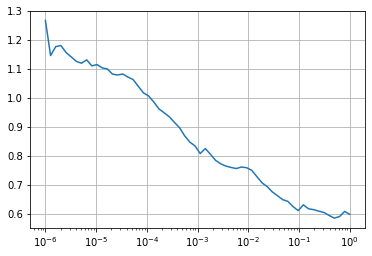

In [38]:
plt.figure()
plt.semilogx(lr_list, loss_list)
plt.grid(True)

- the above learn rate finder shows that lr=1e-3 is a good learning rate to set

- lets complete train one epoch function

In [0]:
# reset the model since we have use lr_finder and weight would have got trained
state = torch.load('/content/initialchkpt.pt')
model.load_state_dict(state['state_dict'])
params = [p for p in  model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=1e-3)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.001)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:

num_batches_train = len(train_dataloader)
num_batches_test  = len(test_dataloader)
def train_one_epoch(model, dataloader, optimizer, device, epoch_num):
    # set the model in train mode
    model.train()
    op_dict = {} # will be returned as op for only end of epoch stats
    output = [] # will contain info for all batches
    batch_num = 0
    for images, targets in dataloader: # returns batch of data every iteration

      # send images in this batch to device
      images = list(image.to(device) for image in images) # list of images
      # send target dict in this bacth to device
      targets = [{k: v.to(device) for k,v in t.items()} for t in targets] # list of dict
      
      # zero out the gradients so that they do not accumulate (default behaviour) in successive passes
      optimizer.zero_grad()
      
      # forward pass
      try:
        loss_dict = model(images, targets)
      except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
          print('| WARNING: ran out of memory, retrying batch', sys.stdout)
          sys.stdout.flush()
          for p in model.parameters():
              if p.grad is not None:
                  del p.grad  # free some memory
          torch.cuda.empty_cache()
          loss_dict = model(images, targets)
        else:
          raise e
      del images, targets

      losses = sum(val for val in loss_dict.values()) 

      # check if overall loss is finite
      if not math.isfinite(losses):
        print("Loss is {}, stopping training".format(losses))
        print(f'epoch:{epoch_num}, batch:{batch_num}/{num_batches_train}')
        sys.exit(1)

      # run backward pass
      losses.backward()
      # update optimizer
      optimizer.step()
    
      output.append([loss_dict['loss_box_reg'].data, loss_dict['loss_classifier'].data, loss_dict['loss_objectness'].data, loss_dict['loss_rpn_box_reg'].data])
      batch_num += 1
      
      print(f'epoch:{epoch_num}, batch:{batch_num}/{num_batches_train}')

      
    
    op_dict['epoch'] = epoch_num
    op_dict['total_loss'] = losses
    op_dict['loss_classifier'] = loss_dict['loss_classifier'].data
    op_dict['loss_box_reg'] = loss_dict['loss_box_reg'].data
    op_dict['loss_objectness'] = loss_dict['loss_objectness'].data
    op_dict['loss_rpn_box_reg'] = loss_dict['loss_rpn_box_reg'].data
    return output, op_dict



-  train over multiple epochs

In [41]:
num_epochs = 10
loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg  = [], [], [], []
for epoch_num in range(num_epochs):
  output, op_dict = train_one_epoch(model, train_dataloader, optimizer, device, epoch_num)
  
  loss_classifier.append(op_dict['loss_classifier'])
  loss_box_reg.append(op_dict['loss_box_reg'])
  loss_objectness.append(op_dict['loss_objectness'])
  loss_rpn_box_reg.append(op_dict['loss_rpn_box_reg'])
  print(f'epoch:{epoch_num}')
  print(f"loss_cls:{op_dict['loss_classifier']}, loss_box_reg:{op_dict['loss_box_reg']}")
  print(f"loss_obj:{op_dict['loss_objectness']}, loss_rpn_reg:{op_dict['loss_rpn_box_reg']}")  

  # run learning rate scheduler step if defined
  if lr_scheduler is not None:
    lr_scheduler.step()
  # evaluate on the test dataset
  pass # TBD

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch:0, batch:1/60
epoch:0, batch:2/60
epoch:0, batch:3/60
epoch:0, batch:4/60
epoch:0, batch:5/60
epoch:0, batch:6/60
epoch:0, batch:7/60
epoch:0, batch:8/60
epoch:0, batch:9/60
epoch:0, batch:10/60
epoch:0, batch:11/60
epoch:0, batch:12/60
epoch:0, batch:13/60
epoch:0, batch:14/60
epoch:0, batch:15/60
epoch:0, batch:16/60
epoch:0, batch:17/60
epoch:0, batch:18/60
epoch:0, batch:19/60
epoch:0, batch:20/60
epoch:0, batch:21/60
epoch:0, batch:22/60
epoch:0, batch:23/60
epoch:0, batch:24/60
epoch:0, batch:25/60
epoch:0, batch:26/60
epoch:0, batch:27/60
epoch:0, batch:28/60
epoch:0, batch:29/60
epoch:0, batch:30/60
epoch:0, batch:31/60
epoch:0, batch:32/60
epoch:0, batch:33/60
epoch:0, batch:34/60
epoch:0, batch:35/60
epoch:0, batch:36/60
epoch:0, batch:37/60
epoch:0, batch:38/60
epoch:0, batch:39/60
epoch:0, batch:40/60
epoch:0, batch:41/60
epoch:0, batch:42/60
epoch:0, batch:43/60
epoch:0, batch:44/60
epoch:0, batch:45/60
epoch:0, batch:46/60
epoch:0, batch:47/60
epoch:0, batch:48/60
e

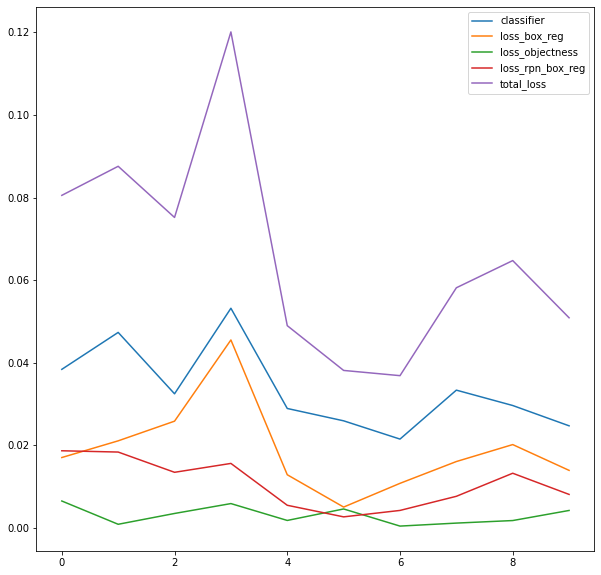

In [42]:
# plot the epoch end stats
total_loss = np.array(loss_classifier) + np.array(loss_box_reg) + np.array(loss_objectness) + np.array(loss_rpn_box_reg)
plt.figure(figsize=(10,10))
plt.plot(np.arange(num_epochs), loss_classifier, label='classifier')
plt.plot(np.arange(num_epochs), loss_box_reg, label='loss_box_reg')
plt.plot(np.arange(num_epochs), loss_objectness, label='loss_objectness')
plt.plot(np.arange(num_epochs), loss_rpn_box_reg, label='loss_rpn_box_reg')
plt.plot(np.arange(num_epochs), total_loss, label='total_loss')
plt.legend()

In [0]:
# save the trained weights
# save the initial model
state = {
    'state_dict': model.state_dict()
    
}
torch.save(state, '/content/ModelafterTrainchkpt.pt')
optim_state = {
    'state_dict': optimizer.state_dict()
}
torch.save(state, '/content/Optimizertrainchkpt.pt')

## Evaluation of object detection algorithm
An object detection algorithm consist of two parts <br>
1. Object Classification, i.e. Class prediction
2. Object Localization, i.e. Bounding box prection

Object classification - We can compute the accuracy easily for this task <br>
Object localization - We will use IOU (intersection over Union) metric to classify sensitivity(Precision) and Recall as defined below

First step if to choose a threshold for IOU measure,say IOU=0.5 (can choose 0.5, 0.6, 0.7 - are some of the good choices)

`True Positive (TP)`: If predicted bounding box has IOU >= 0.5 along with classification score greater than threshold, with any of the ground truth box <br>
`False Positive (FP)`: If predicted bounding box has IOU < 0.5 <br> or classification score less than threshold <br>
`False Negative (FN)`: When ground truth is present and model failed to detect it <br>
`True Negative (TN)`: This is every part of part of image which is note detected as object, not too useful for object localization and will not be considered here <br>

### Precision and Recall
Precision = TP/(TP + FP) = TP/(Number of predicted ROI proposals) <br>
Recall = TP/(TP + FN) = TP/(Number of Ground Truth ROI porposals) <br>

`Precision` is the ratio of True Positive to all the predicted positive, it tells you if you pick a positive predicted item, what is the chance that it is truly positive. Also known as  PPV (Positive Predictive value). We would like this number to be close to 1. (Higher the better)

`Recall` is the ratio of True Positive to all the ground truth positive. Also known as sensitivity. It measures the ability to currectly classify all ground truth positives as positive. We would like this number to be close to 1. (Higher the better)



In [0]:
# compute IOU for a ROI from localizer for a given image
def  compute_IOU(pred_box_cord, ground_truth_box_cord):
  '''
  [1] pred_box_cord: np.array, x0,y0,x1,y1 cordinates of prediction box
  [2] ground_truth_box_cord: np.array, x0,y0,x1,y1 for ground truth boxes
  '''
  num_gt = len(ground_truth_box_cord)
  IOU = np.zeros(num_gt) # for every predicted box, compute IOU with all ground truth boxes
  x0, y0, x1, y1 = pred_box_cord[0], pred_box_cord[1], pred_box_cord[2], pred_box_cord[3]
  area_pred = (x1-x0)*(y1-y0)
  x0_g, y0_g, x1_g, y1_g = ground_truth_box_cord[0], ground_truth_box_cord[1], ground_truth_box_cord[2], ground_truth_box_cord[3]
  area_gt = (x1_g - x0_g)*(y1_g - y0_g)
    
  xmax = np.max([x0,x0_g])
  xmin = np.min([x1,x1_g])
  ymax = np.max([y0,y0_g])
  ymin = np.min([y1,y1_g])
  if (xmax < xmin) and (ymax < ymin): # there is overlap
    overlap_area = (xmin - xmax) *(ymin - ymax)
    IOU = overlap_area / (area_pred + area_gt - overlap_area)
  else:
    IOU =0
  return IOU


In [0]:
# Code Credit: https://github.com/omarfoq/Pedestrian_Detection
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
  """
  For a given sample, gets if each detection is a True Positive or a False positive
  :param target_pred : dictionary describing the predicted detection (should have 'boxes', 'labels', 'scores')
  :param target_true : dictionary describing the ground truth (should have 'boxes', 'labels')
  :param iou_threshold: The treshold on IoU, to judge if a detection is correct or not
  :return : List of dictionaries with same size as detections, each dict have keys
            'score'  and 'TP' (= 1 if true positive and 0 otherwise)
  """
  gt_bboxes = target_true['boxes'].numpy()
  gt_labels = target_true['labels'].numpy()

  dt_bboxes = target_pred['boxes'].numpy()
  dt_labels = target_pred['labels'].numpy()
  dt_scores = target_pred['scores'].numpy()

  results = []
  for detection_id in range(len(dt_labels)): # loop over every detection
    dt_bbox = dt_bboxes[detection_id, :]
    dt_label = dt_labels[detection_id]
    dt_score = dt_scores[detection_id]

    detection_result_dict = {'score': dt_score}

    max_IoU = 0
    max_gt_id = -1
    for gt_id in range(len(gt_labels)): # loop over ground truth
      gt_bbox = gt_bboxes[gt_id, :]
      gt_label = gt_labels[gt_id]

      if gt_label != dt_label:
        continue

      if compute_IOU(dt_bbox, gt_bbox) > max_IoU:
        max_IoU = compute_IOU(dt_bbox, gt_bbox)
        max_gt_id = gt_id

    if max_gt_id >= 0 and max_IoU >= iou_threshold:
      detection_result_dict['TP'] = 1
      gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
      gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

    else:
      detection_result_dict['TP'] = 0

    results.append(detection_result_dict)

  return results

In [0]:
# Code Credit: https://github.com/omarfoq/Pedestrian_Detection
def evaluate(model, test_loader, device):
  '''
  computes precision and recall for for given threshold (default of 0.5)
  returns tuple containing precision and recall
  '''
  results = []
  model.eval()
  nbr_boxes = 0
  with torch.no_grad():
    for batch, (images, targets_true) in enumerate(test_loader):
      images = list(image.to(device).float() for image in images)
      targets_pred = model(images) # output is a list of dictionaries with each one having keys: boxes, labels, scores

      targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
      targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

      for ii in range(len(targets_true)): # loop over number of images in the batch
        target_true = targets_true[ii]
        target_pred = targets_pred[ii]
        nbr_boxes += target_true['labels'].shape[0]

        results = results + evaluate_sample(target_pred, target_true)

    results = sorted(results, key=lambda k: k['score'], reverse=True) # sort iterable (list in this case) based on dictionary key: 'score'

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP']==1:
      acc_TP[0] = 1
    else:
      acc_FP[0] = 1

    # compute accumulated TP and FP
    for i in range(1,len(results)):
      # calculate acc TP and FP
      acc_TP[i] = acc_TP[i-1] + results[i]['TP']
      acc_FP[i] = acc_FP[i-1] + (1 - results[i]['TP'])
      # calculate precision and recall
      precision[i] = acc_TP[i]/(acc_TP[i] + acc_FP[i])
      recall[i] = acc_TP[i]/nbr_boxes

    return auc(recall, precision) 



## Train with val metric updates

In [0]:
# reset the weights
# reset the model since we have use lr_finder and weight would have got trained
state = torch.load('/content/initialchkpt.pt')
model.load_state_dict(state['state_dict'])
params = [p for p in  model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=1e-3)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.001)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [48]:
num_epochs = 10
loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg  = [], [], [], []
for epoch_num in range(num_epochs):

  start = time.time()
  output, op_dict = train_one_epoch(model, train_dataloader, optimizer, device, epoch_num)
  mAP = evaluate(model, test_dataloader, device)
  end = time.time()
  
  loss_classifier.append(op_dict['loss_classifier'])
  loss_box_reg.append(op_dict['loss_box_reg'])
  loss_objectness.append(op_dict['loss_objectness'])
  loss_rpn_box_reg.append(op_dict['loss_rpn_box_reg'])
  print(f'epoch:{epoch_num}')
  print(f"loss_cls:{op_dict['loss_classifier']}, loss_box_reg:{op_dict['loss_box_reg']}")
  print(f"loss_obj:{op_dict['loss_objectness']}, loss_rpn_reg:{op_dict['loss_rpn_box_reg']}")  
  print(f'Time for train+eval: {end - start}')
  print(f'mAP: {mAP}')

  # run learning rate scheduler step if defined
  if lr_scheduler is not None:
    lr_scheduler.step()

  
  # save model every 3 epochs
  if (epoch_num+1) % 3 == 0:
    print(f'saving model afte epoch: {epoch_num}')
    torch.save(model.state_dict(), os.path.join('/content/', 'model_dict_' + str(epoch_num)+".pth"))
  
# save the final trained model
torch.save(model.state_dict(), os.path.join('/content/', 'model_dict_' + str(epoch_num)+".pth"))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch:0, batch:1/60
epoch:0, batch:2/60
epoch:0, batch:3/60
epoch:0, batch:4/60
epoch:0, batch:5/60
epoch:0, batch:6/60
epoch:0, batch:7/60
epoch:0, batch:8/60
epoch:0, batch:9/60
epoch:0, batch:10/60
epoch:0, batch:11/60
epoch:0, batch:12/60
epoch:0, batch:13/60
epoch:0, batch:14/60
epoch:0, batch:15/60
epoch:0, batch:16/60
epoch:0, batch:17/60
epoch:0, batch:18/60
epoch:0, batch:19/60
epoch:0, batch:20/60
epoch:0, batch:21/60
epoch:0, batch:22/60
epoch:0, batch:23/60
epoch:0, batch:24/60
epoch:0, batch:25/60
epoch:0, batch:26/60
epoch:0, batch:27/60
epoch:0, batch:28/60
epoch:0, batch:29/60
epoch:0, batch:30/60
epoch:0, batch:31/60
epoch:0, batch:32/60
epoch:0, batch:33/60
epoch:0, batch:34/60
epoch:0, batch:35/60
epoch:0, batch:36/60
epoch:0, batch:37/60
epoch:0, batch:38/60
epoch:0, batch:39/60
epoch:0, batch:40/60
epoch:0, batch:41/60
epoch:0, batch:42/60
epoch:0, batch:43/60
epoch:0, batch:44/60
epoch:0, batch:45/60
epoch:0, batch:46/60
epoch:0, batch:47/60
epoch:0, batch:48/60
e

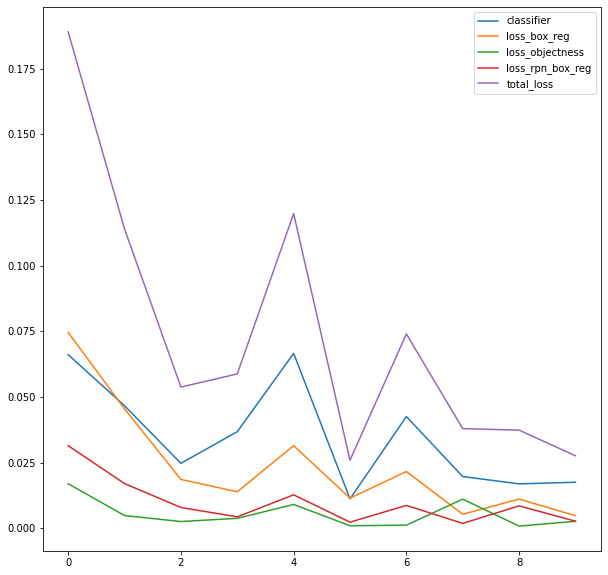

In [49]:
# plot the epoch end stats
total_loss = np.array(loss_classifier) + np.array(loss_box_reg) + np.array(loss_objectness) + np.array(loss_rpn_box_reg)
plt.figure(figsize=(10,10))
plt.plot(np.arange(num_epochs), loss_classifier, label='classifier')
plt.plot(np.arange(num_epochs), loss_box_reg, label='loss_box_reg')
plt.plot(np.arange(num_epochs), loss_objectness, label='loss_objectness')
plt.plot(np.arange(num_epochs), loss_rpn_box_reg, label='loss_rpn_box_reg')
plt.plot(np.arange(num_epochs), total_loss, label='total_loss')
plt.legend()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Number of Ground Truth Instances in Image: 1
Number of Predicted Instances in Image: 5


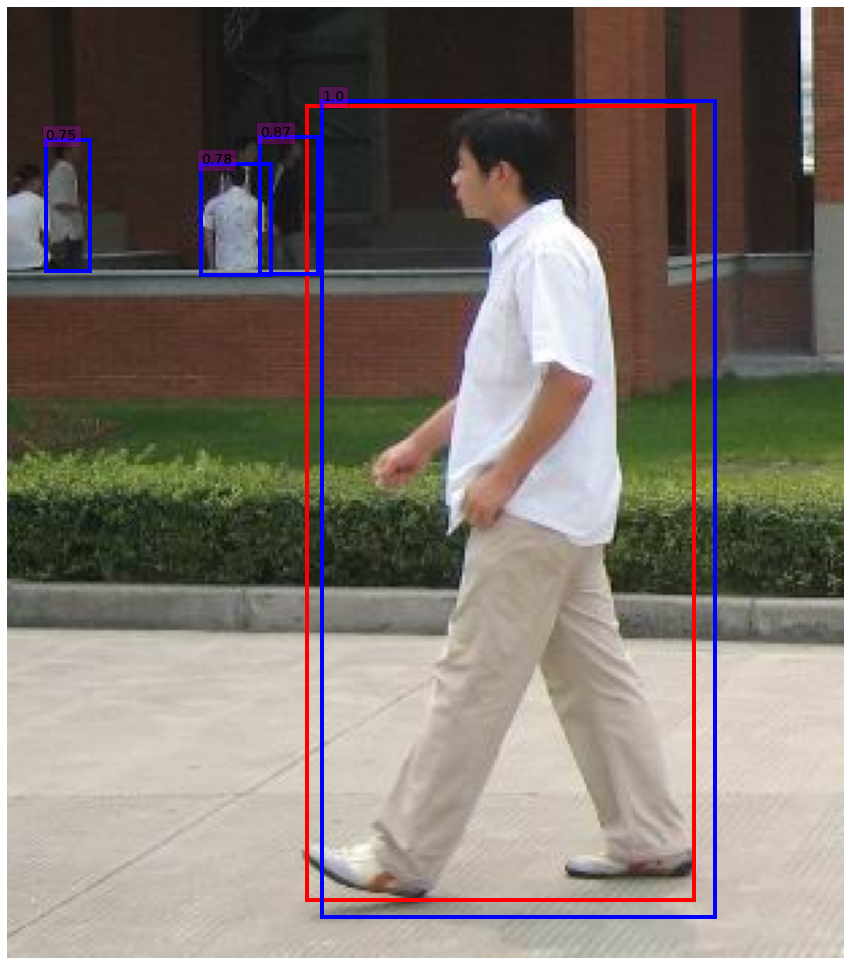

In [51]:
idx = np.random.choice(len(test_dataset_)) #4, 47
image, target_gt = test_dataset_[idx]
#{{perform prediction
state = torch.load('/content/model_dict_9.pth')
model.load_state_dict(state)
model.to(device)
imagecopy = image.clone()
imagecopy.unsqueeze_(0) # add batch dimension
imagecopy = list(imagecopy.to(device)) # list of image
model.eval()
with torch.no_grad():
  target_pred = model(imagecopy) # in eval mode, only image is sent as input
target_pred = [{k: v.to("cpu") for k,v in t.items()} for t in target_pred]
target_pred = target_pred[0] # picking 1st element of list which is dict since there is only 1 image for prediction
#}}
image = image.numpy()
image = np.transpose(image, axes=[1,2,0])
fig, ax = plt.subplots(1, figsize=(15,20))
ax.imshow(image)
ax.axis('off')
print(f'Number of Ground Truth Instances in Image: {target_gt["boxes"].shape[0]}')
# draw bounding boxes
num_obj = target_gt["boxes"].shape[0]
for i in range(num_obj):
    # Create a Rectangle patch
    curr_box = (target_gt["boxes"][i]).numpy()
    x0,y0,x1,y1 = curr_box[0], curr_box[1], curr_box[2], curr_box[3]
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0,y0),width,height,linewidth=4,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

# draw detection boxes
num_obj_pred = target_pred["boxes"].shape[0]
print(f'Number of Predicted Instances in Image: {target_pred["boxes"].shape[0]}')

for i in range(num_obj_pred):
    # Create a Rectangle patch
    curr_box = (target_pred["boxes"][i]).numpy()
    confidence = (target_pred["scores"][i]).numpy()
    confidence = np.round(confidence, 2)
    if confidence < 0.7:
      continue
    x0,y0,x1,y1 = curr_box[0], curr_box[1], curr_box[2], curr_box[3]
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0,y0),width,height,linewidth=4,edgecolor='b',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    # add confidence as text
    ax.annotate(str(confidence), (x0,y0), fontsize=14, bbox={'facecolor': 'm', 'alpha': 0.3, 'pad': 4})

plt.show()

In [113]:
target_pred = [{k: v.to("cpu") for k,v in t.items()} for t in target_pred]
target_pred

[{'boxes': tensor([[230.5084, 131.8181, 329.4771, 405.7962],
          [133.4632, 136.7592, 198.7087, 314.6825]]),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9954, 0.9954])}]